In [38]:
import open3d as o3d
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.collections as mcoll
from matplotlib.collections import LineCollection


In [41]:
# Load the intraoral mesh
intraoral_mesh = o3d.io.read_triangle_mesh(r'D:\sunny\Codes\DPS\data_teethseg\origin\000101_origin.ply')
intraoral_mesh.compute_vertex_normals()

TriangleMesh with 20615 points and 39985 triangles.

### 1. Create Splines and Extrude to Curve Planes as Projection Screens

In [95]:
# Calculate theta values for each vertex
points = np.asarray(intraoral_mesh.vertices)
x, z = points[:, 0], points[:, 2]
theta = np.arctan2(z, x) + np.pi/2
theta = np.mod(theta, 2*np.pi)

# find points with min and max theta values
min_theta_idx = np.argmin(theta)
max_theta_idx = np.argmax(theta)
endpt1 = points[min_theta_idx]
endpt2 = points[max_theta_idx]


# find the point with smallest x value
endpt0 = points[np.argmin(abs(x))]


ellipse_centre = (endpt1 + endpt2) / 2
# move both endpts slightly away from the centre of ellipse
outer_endpt1 = endpt1 + 0.64 * (endpt1 - ellipse_centre)
outer_endpt2 = endpt2 + 0.64 * (endpt2 - ellipse_centre)
outer_endpt0 = endpt0 + 0.32 * (endpt0 - ellipse_centre)

outer_ellipse_points = np.array([outer_endpt1, outer_endpt0, outer_endpt2])
# set y values of all outer_spline_points to 0
outer_ellipse_points[:, 1] = 0

# Visualize the 3 end points as point clouds and the mesh with open3d
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(outer_spline_points)
pc.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([intraoral_mesh, pc])


In [65]:
# Function to create a half ellipse from 3 points
def create_ellipse_curve(ellipse_points):
    assert ellipse_points.shape == (3, 3), "Input must be a 3x3 array"
    

# Create splines for outer and inner points
outer_spline_points = create_spline(outer_points)
inner_spline_points = create_spline(inner_points)

# Visualize the splines 
outer_spline_pc = o3d.geometry.PointCloud()
outer_spline_pc.points = o3d.utility.Vector3dVector(outer_spline_points)
outer_spline_pc.paint_uniform_color([1, 0, 0])
inner_spline_pc = o3d.geometry.PointCloud()
inner_spline_pc.points = o3d.utility.Vector3dVector(inner_spline_points)
inner_spline_pc.paint_uniform_color([0, 1, 0])

o3d.visualization.draw_geometries([intraoral_mesh, outer_spline_pc, inner_spline_pc])

Extrude the Spline Points to Create Curved Plane Mesh

In [64]:
# Function to extrude spline points
def extrude_spline(points, extrusion_length_pos, extrusion_length_neg):
    extruded_points_pos = points + np.array([0, extrusion_length_pos, 0])
    extruded_points_neg = points + np.array([0, extrusion_length_neg, 0])
    extruded_points = np.vstack((points, extruded_points_pos, extruded_points_neg))
    return extruded_points

# Calculate the extrusion length
y_min = np.min(points[:, 1])
y_max = np.max(points[:, 1])
extrusion_length_pos = y_max
extrusion_length_neg = y_min
print(f'Extrusion length: {extrusion_length_pos} (pos), {extrusion_length_neg} (neg)')

# Create curved planes
curved_plane_outer_points = extrude_spline(outer_spline_points, extrusion_length_pos, extrusion_length_neg)
curved_plane_inner_points = extrude_spline(inner_spline_points, extrusion_length_pos, extrusion_length_neg)


Extrusion length: 10.682730266372726 (pos), -0.62988083750371 (neg)


Create meshes for visualization:

In [56]:
# Function to create Open3D mesh from points
def create_open3d_mesh(points):
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(points)
    mesh.triangles = o3d.utility.Vector3iVector([[i, i+1, i+2] for i in range(len(points) - 2)])
    mesh.compute_vertex_normals()
    return mesh

# Create Open3D meshes for curved planes
curved_plane_outer = create_open3d_mesh(curved_plane_outer_points)
curved_plane_inner = create_open3d_mesh(curved_plane_inner_points)

# Visualize the meshes
o3d.visualization.draw_geometries([intraoral_mesh, curved_plane_outer, curved_plane_inner],
                                  mesh_show_back_face=True,
                                  window_name='Curved Planes Visualization')



### 2. Projections

In [112]:
# Calculate vertex normals
intraoral_mesh.compute_vertex_normals()
vertex_normals = np.asarray(intraoral_mesh.vertex_normals)
vertices = np.asarray(intraoral_mesh.vertices)
faces = np.asarray(intraoral_mesh.triangles)
colors = np.asarray(intraoral_mesh.vertex_colors)

# Classify vertices as inward or outward-facing
outward_facing_mask = np.array([np.dot(normal, vertex) > 0 for normal, vertex in zip(vertex_normals, vertices)])
inward_facing_mask = np.array([np.dot(normal, vertex) < 0 for normal, vertex in zip(vertex_normals, vertices)])
# assert np.sum(outward_facing_mask) + np.sum(inward_facing_mask) == len(vertices), 'Some vertices are not classified'


# Extract inward and outward-facing vertices and colors
outward_facing_vertices = vertices[outward_facing_mask]
outward_facing_colors =colors[outward_facing_mask]
inward_facing_vertices = vertices[inward_facing_mask]
inward_facing_colors = colors[inward_facing_mask]

# Extract inward and outward-facing faces
outward_facing_faces = []
inward_facing_faces = []
for face in faces:
    if np.all(outward_facing_mask[face]): # if all vertices of the face are outward facing
        outward_facing_faces.append(face) # add the face to the outward facing faces
    elif np.all(inward_facing_mask[face]): # if all vertices of the face are inward facing
        inward_facing_faces.append(face) # add the face to the inward facing faces


# for each face, convert indices from original to new vertex indices
outward_facing_idx = np.where(outward_facing_mask)[0]
inward_facing_idx = np.where(inward_facing_mask)[0]

# Create a mapping from old indices to new indices
outward_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(outward_facing_idx)}
inward_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(inward_facing_idx)}

# Vectorized approach to update face indices
outward_facing_faces = np.vectorize(outward_idx_map.get)(outward_facing_faces)
inward_facing_faces = np.vectorize(inward_idx_map.get)(inward_facing_faces)



In [113]:
# Project vertices onto the respective cylinders
def project_onto_cylinder(vertices, radius):
    projected_vertices = vertices.copy()
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)
        projected_vertices[i] = [radius * np.cos(theta), y, radius * np.sin(theta)]
    return projected_vertices

In [114]:
projected_outward_vertices = project_onto_cylinder(outward_facing_vertices, outer_radius)
projected_inward_vertices = project_onto_cylinder(inward_facing_vertices, inner_radius)

# Create meshes for the projected vertices
projected_outward_mesh = o3d.geometry.PointCloud()
projected_outward_mesh.points = o3d.utility.Vector3dVector(projected_outward_vertices)
projected_outward_mesh.colors = o3d.utility.Vector3dVector(outward_facing_colors)

projected_inward_mesh = o3d.geometry.PointCloud()
projected_inward_mesh.points = o3d.utility.Vector3dVector(projected_inward_vertices)
projected_inward_mesh.colors = o3d.utility.Vector3dVector(inward_facing_colors)

In [115]:
# Create a new mesh for visualization
new_mesh = copy.deepcopy(intraoral_mesh)
new_vertices = np.asarray(new_mesh.vertices)
new_vertices[outward_facing_mask] = projected_outward_vertices
new_vertices[inward_facing_mask] = projected_inward_vertices
new_mesh.vertices = o3d.utility.Vector3dVector(new_vertices)

# Visualize the original mesh, projected meshes, and coordinate axes
o3d.visualization.draw_geometries([intraoral_mesh, projected_outward_mesh, projected_inward_mesh, coordinate_frame, cylinder_outer, cylinder_inner])

### 3. Visualize with 2D Flattening

In [116]:
# Flatten the projected vertices into 2D planes
def flatten_to_2d(vertices):
    flattened_vertices = []
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)
        if theta < -np.pi/2:
            theta += 2 * np.pi
        flattened_vertices.append([theta, y])
    return np.array(flattened_vertices)

# Flatten the projected vertices into 2D planes
uv_outward = flatten_to_2d(projected_outward_vertices)
uv_inward = flatten_to_2d(projected_inward_vertices)


##### Proper visualization with original colors

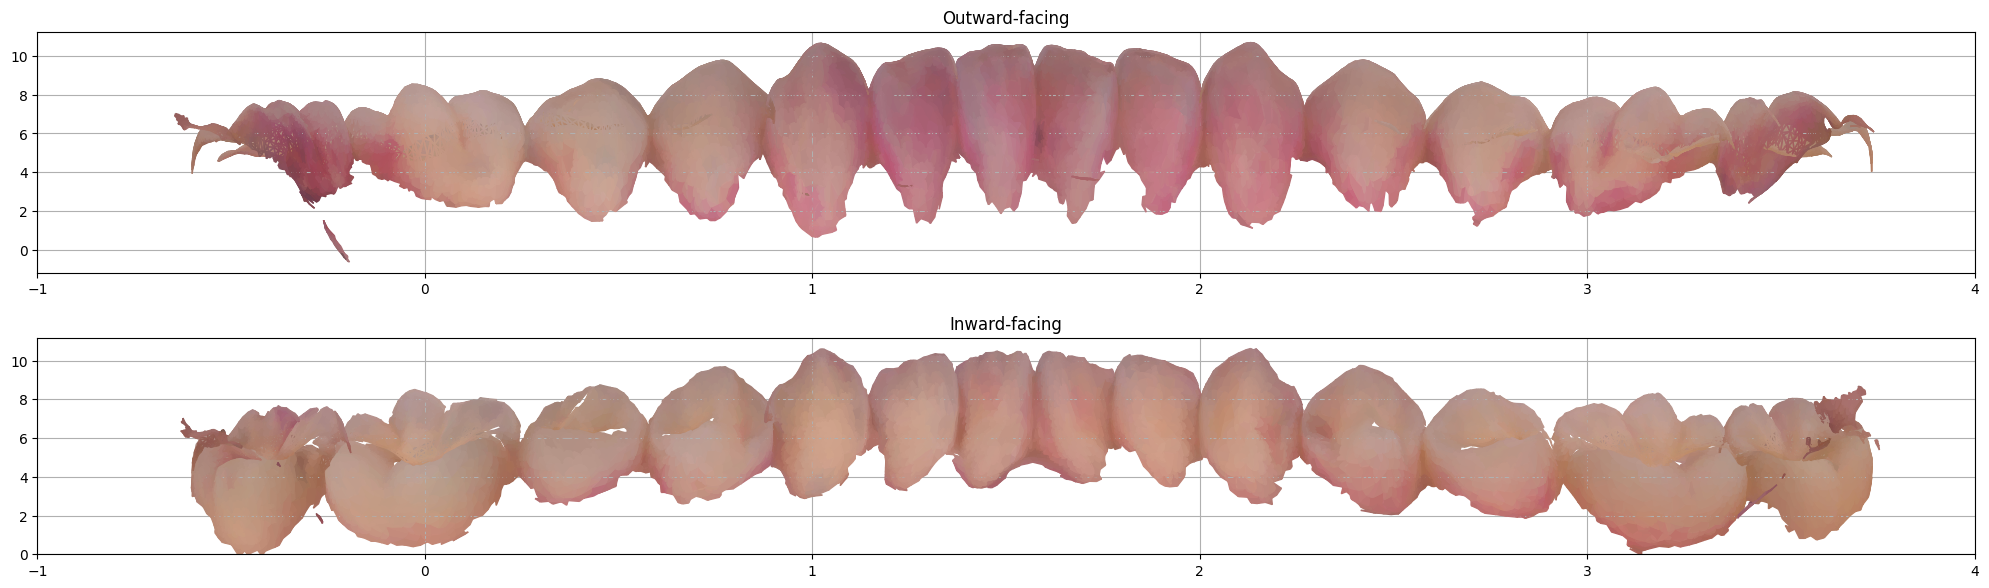

In [139]:
# Function to get the minimum color for each triangle
def get_min_triangle_colors(triangles, colors):
    triangle_colors = []
    for tri in triangles:
        # Extract the colors of the vertices
        color1, color2, color3 = colors[tri[0]], colors[tri[1]], colors[tri[2]]
        # Get the minimum color value (element-wise)
        min_color = np.minimum(np.minimum(color1, color2), color3)
        triangle_colors.append(min_color)
    return np.array(triangle_colors)

# Function to get the minimum color for each edge
def get_min_edge_colors(triangles, colors):
    edge_colors = []
    edges = []
    for tri in triangles:
        # Extract the colors of the vertices
        color1, color2, color3 = colors[tri[0]], colors[tri[1]], colors[tri[2]]
        # Define edges as pairs of vertices
        edges.extend([(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])])
        # Get the minimum color value (element-wise) for each edge
        edge_colors.append(np.minimum(color1, color2))
        edge_colors.append(np.minimum(color2, color3))
        edge_colors.append(np.minimum(color3, color1))
    return edges, np.array(edge_colors)

"""##################################################### Extract face colors ########################################################"""
# Get the minimum colors for each triangle
outward_triangle_colors = get_min_triangle_colors(outward_facing_faces, outward_facing_colors)
inward_triangle_colors = get_min_triangle_colors(inward_facing_faces, inward_facing_colors)

# Convert triangle vertices to a list of polygons
outward_polygons = [[uv_outward[v[0]], uv_outward[v[1]], uv_outward[v[2]]] for v in outward_facing_faces]
inward_polygons = [[uv_inward[v[0]], uv_inward[v[1]], uv_inward[v[2]]] for v in inward_facing_faces]

# Create PolyCollections
outward_collection = mcoll.PolyCollection(outward_polygons, facecolors=outward_triangle_colors, edgecolors='none', linewidths=0)
inward_collection = mcoll.PolyCollection(inward_polygons, facecolors=inward_triangle_colors, edgecolors='none', linewidths=0)

"""##################################################### Extract edge colors ########################################################"""
# Get the edge colors and edges
outward_edges, outward_edge_colors = get_min_edge_colors(outward_facing_faces, outward_facing_colors)
inward_edges, inward_edge_colors = get_min_edge_colors(inward_facing_faces, inward_facing_colors)

# Create line segments for the edges
outward_segments = [[uv_outward[v1], uv_outward[v2]] for v1, v2 in outward_edges]
inward_segments = [[uv_inward[v1], uv_inward[v2]] for v1, v2 in inward_edges]

# Create LineCollections
outward_lines = LineCollection(outward_segments, colors=outward_edge_colors, linewidths=1)
inward_lines = LineCollection(inward_segments, colors=inward_edge_colors, linewidths=1)


"""########################################## Plot the triangulated mesh with colored faces and edges ###########################################"""
# Plot the triangulated mesh with colored faces
fig, ax = plt.subplots(2, 1, figsize=(25, 7))

# Plot outward-facing vertices
ax[0].add_collection(outward_collection)
ax[0].add_collection(outward_lines)
ax[0].autoscale_view()
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xlim([-1, 4])
ax[0].set_title('Outward-facing')
ax[0].set_aspect(aspect=0.05)
ax[0].grid(True)

# Plot inward-facing vertices
ax[1].add_collection(inward_collection)
ax[1].add_collection(inward_lines)
ax[1].autoscale_view()
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_xlim([-1, 4])
ax[1].set_ylim([0, None])
ax[1].set_title('Inward-facing')
ax[1].set_aspect(aspect=0.05)
ax[1].grid(True)

plt.show()


#### Other visualization

##### Visualize vertices directly

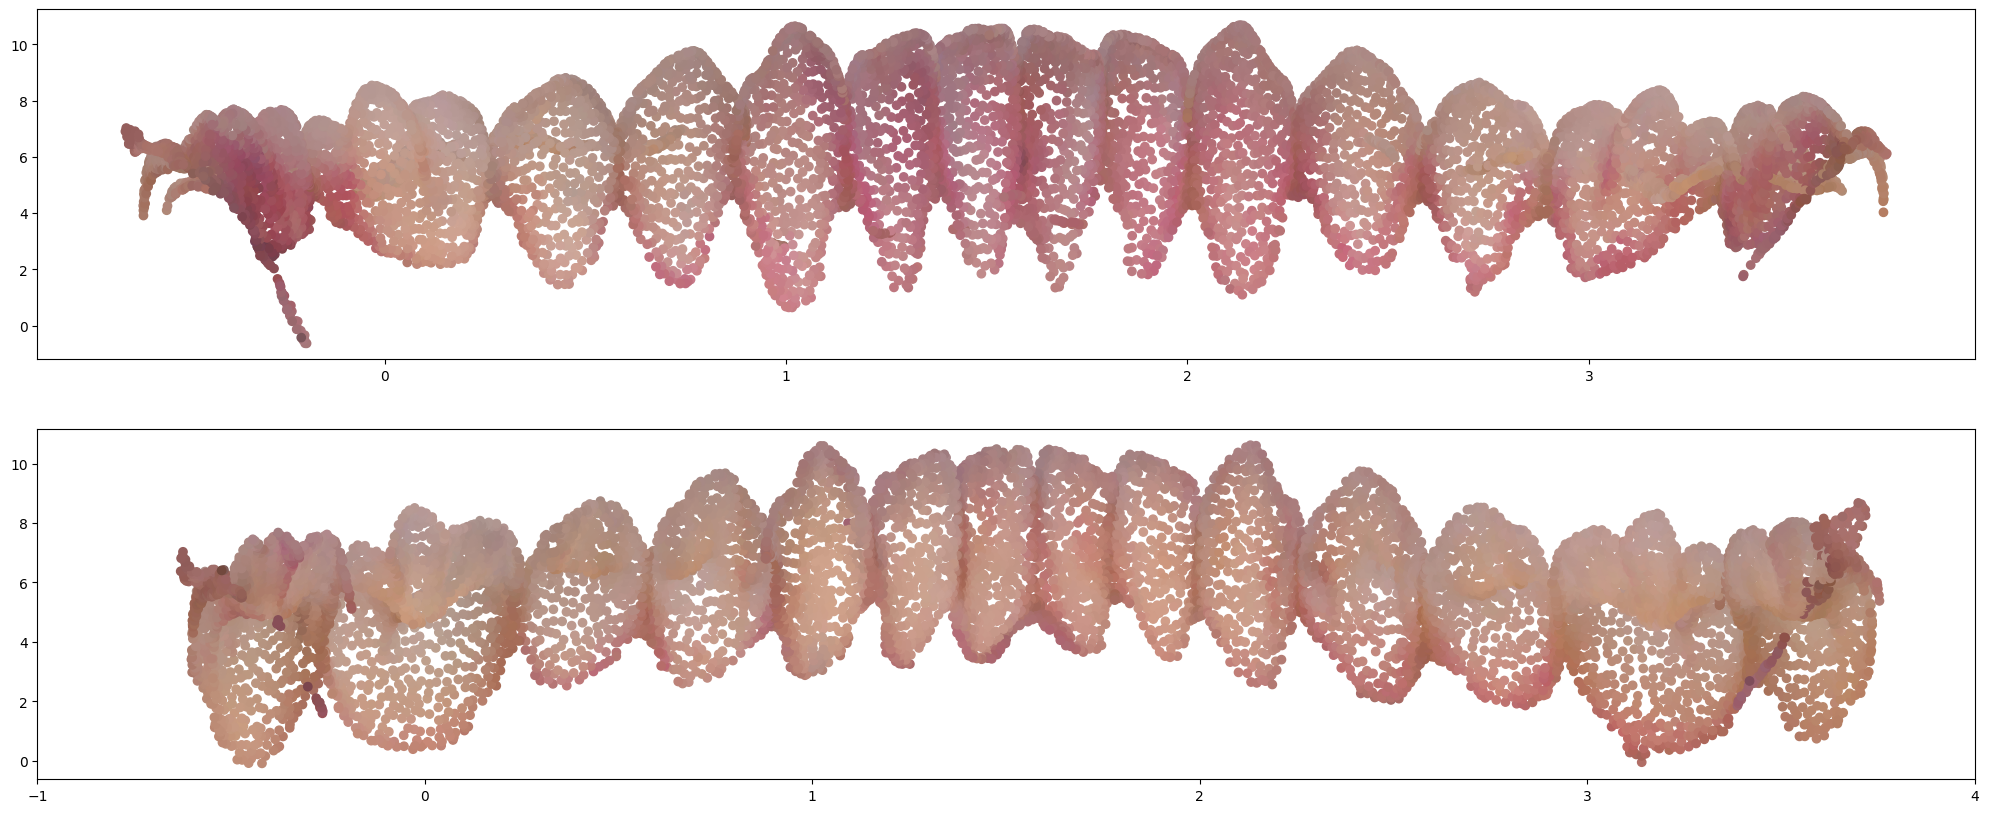

In [71]:
# # Visualize the flattened vertices
# fig, ax = plt.subplots(2,1,figsize=(25, 10))
# ax[0].scatter(uv_outward[:, 0], uv_outward[:, 1], c=outward_facing_colors, label='Outward-facing')
# ax[1].scatter(uv_inward[:, 0], uv_inward[:, 1], c=inward_facing_colors, label='Inward-facing')
# plt.xlim(-1,4)
# plt.show()


##### Visualize in terms of single-channel luminance

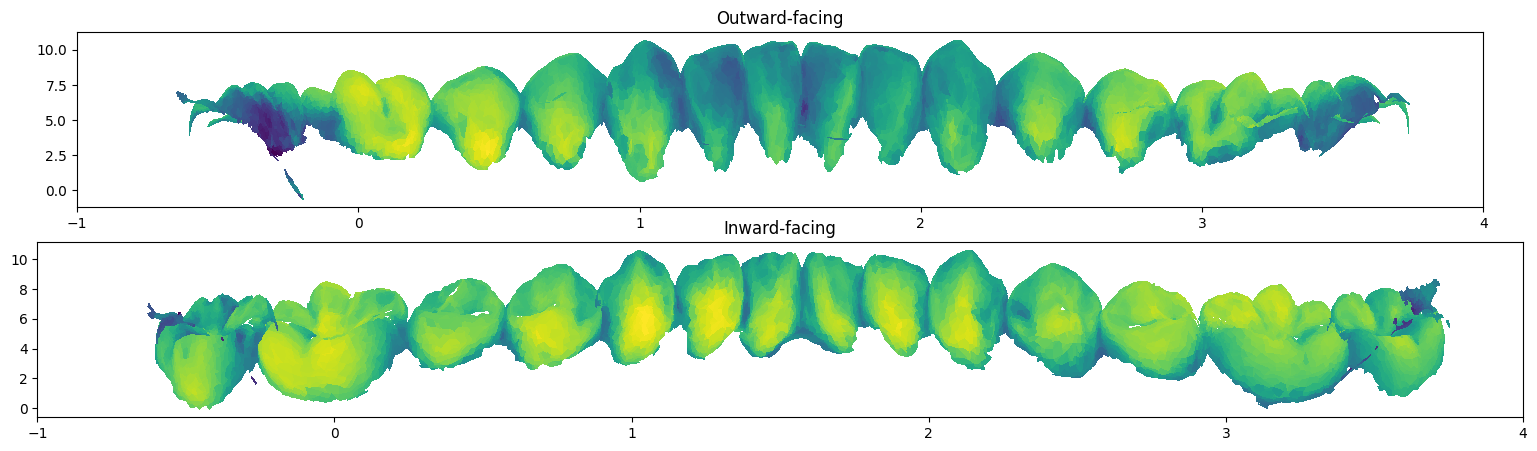

In [38]:
# # Function to get the minimum color for each triangle
# def get_min_triangle_colors(triangles, colors):
#     triangle_colors = []
#     for tri in triangles:
#         # Extract the colors of the vertices
#         color1, color2, color3 = colors[tri[0]], colors[tri[1]], colors[tri[2]]
#         # Get the minimum color value (element-wise)
#         min_color = np.minimum(np.minimum(color1, color2), color3)
#         triangle_colors.append(min_color)
#     return np.array(triangle_colors)

# # Get the minimum colors for each triangle
# outward_triangle_colors = get_min_triangle_colors(outward_facing_faces, outward_facing_colors)
# inward_triangle_colors = get_min_triangle_colors(inward_facing_faces, inward_facing_colors)

# # Convert RGB colors to a single value (e.g., using luminance formula)
# def rgb_to_luminance(colors):
#     return 0.2126 * colors[:, 0] + 0.7152 * colors[:, 1] + 0.0722 * colors[:, 2]

# outward_triangle_luminance = rgb_to_luminance(outward_triangle_colors)
# inward_triangle_luminance = rgb_to_luminance(inward_triangle_colors)

# # Create a triangulation object
# outward_triang = mtri.Triangulation(uv_outward[:, 0], uv_outward[:, 1], outward_facing_faces)
# inward_triang = mtri.Triangulation(uv_inward[:, 0], uv_inward[:, 1], inward_facing_faces)

# # Plot the triangulated mesh with colored faces
# fig, ax = plt.subplots(2, 1, figsize=(20,5))
# ax[0].tripcolor(outward_triang, facecolors=outward_triangle_luminance, edgecolors='none')
# ax[0].set_aspect('equal', adjustable='box')
# ax[0].set_xlim([-1, 4])
# ax[0].set_title('Outward-facing')

# ax[1].tripcolor(inward_triang, facecolors=inward_triangle_luminance, edgecolors='none')
# ax[1].set_aspect('equal', adjustable='box')
# ax[1].set_xlim([-1, 4])
# ax[1].set_title('Inward-facing')
# ax[0].set_aspect(aspect=0.05)
# ax[1].set_aspect(aspect=0.05)


### 4. Test 2D to 3D backprojection with color manipulation

In [141]:

# Set colors of all vertices with uv coordinates of theta < 1 to red
def set_test_colors(vertice_colors, uv_coordinates):
    new_vertice_colors = copy.deepcopy(vertice_colors)
    for i in range(len(uv_coordinates)):
        if uv_coordinates[i][0] < 0:
            new_vertice_colors[i] = [1, 0, 0]
        elif uv_coordinates[i][0] < 1:
            new_vertice_colors[i] = [1, 1, 0]
        elif uv_coordinates[i][0] < 2:
            new_vertice_colors[i] = [0, 1, 0]
        elif uv_coordinates[i][0] < 3:
            new_vertice_colors[i] = [0, 1, 1]
        else:
            new_vertice_colors[i] = [0, 0, 1]


    return new_vertice_colors

outward_facing_colors_new = set_test_colors(outward_facing_colors, uv_outward)
inward_facing_colors_new = set_test_colors(inward_facing_colors, uv_inward)


# Create a new mesh with original vertices and updated colors
new_mesh = copy.deepcopy(intraoral_mesh)
new_colors = np.asarray(new_mesh.vertex_colors)


for (old_idx,color) in enumerate(new_colors):
    if outward_facing_mask[old_idx]:
        new_idx = outward_idx_map[old_idx]
        new_colors[old_idx] = outward_facing_colors_new[new_idx]
    elif inward_facing_mask[old_idx]:
        new_idx = inward_idx_map[old_idx]
        new_colors[old_idx] = inward_facing_colors_new[new_idx]
    else:
        print("Non-classified vertices!")

new_mesh.vertex_colors = o3d.utility.Vector3dVector(new_colors)
#visualization of the new mesh
o3d.visualization.draw_geometries([new_mesh, coordinate_frame])




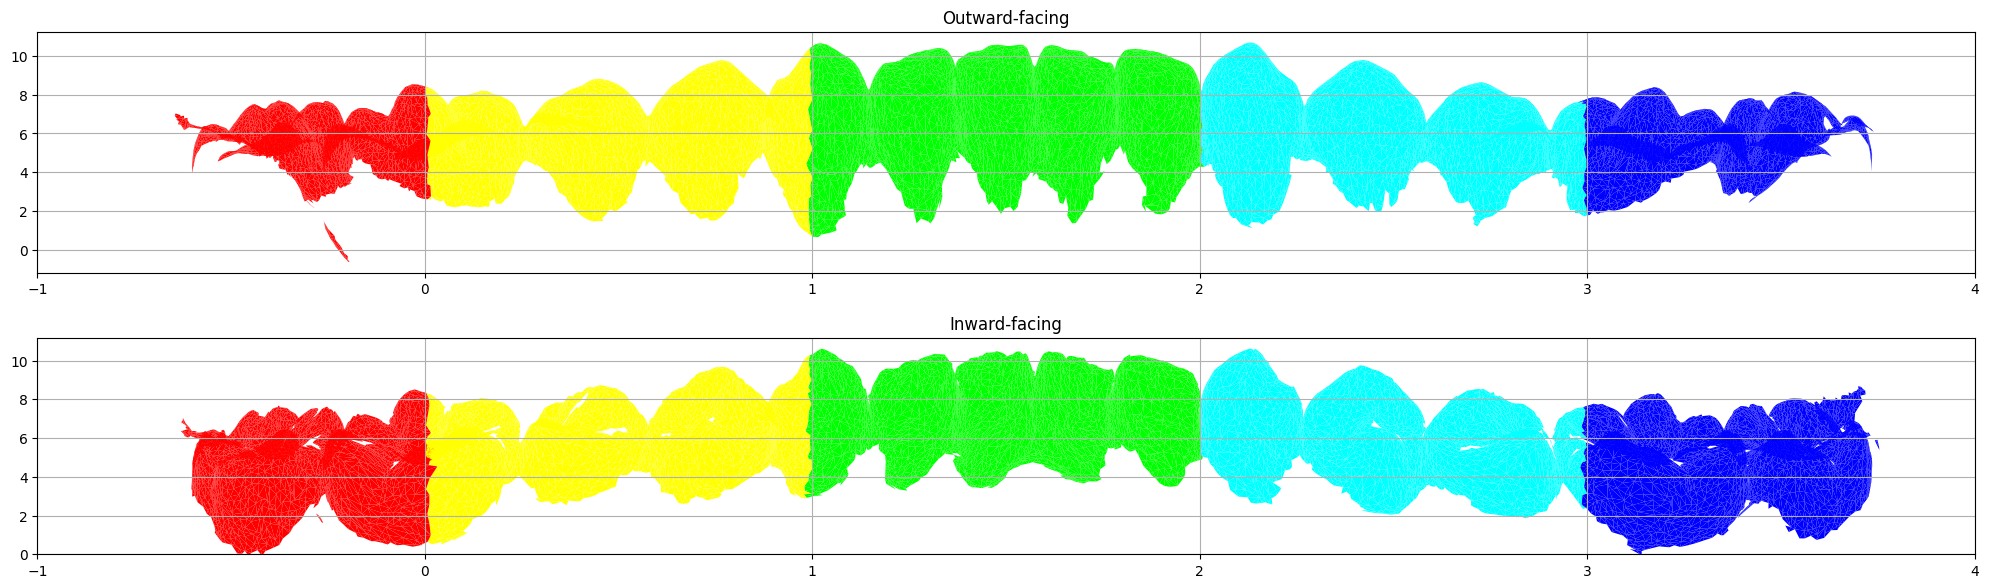

In [140]:
# Get the minimum colors for each triangle
outward_triangle_colors_new = get_min_triangle_colors(outward_facing_faces, outward_facing_colors_new)
inward_triangle_colors_new = get_min_triangle_colors(inward_facing_faces, inward_facing_colors_new)


# Create PolyCollections
outward_collection = mcoll.PolyCollection(outward_polygons, facecolors=outward_triangle_colors_new, edgecolors='none', linewidths=0)
inward_collection = mcoll.PolyCollection(inward_polygons, facecolors=inward_triangle_colors_new, edgecolors='none', linewidths=0)

# Plot the triangulated mesh with colored faces
fig, ax = plt.subplots(2, 1, figsize=(25, 7))

# Plot outward-facing vertices
ax[0].add_collection(outward_collection)
# ax[0].add_collection(outward_lines)
ax[0].autoscale_view()
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xlim([-1, 4])
ax[0].set_title('Outward-facing')
ax[0].set_aspect(aspect=0.05)
ax[0].grid(True)

# Plot inward-facing vertices
ax[1].add_collection(inward_collection)
# ax[1].add_collection(inward_lines)
ax[1].autoscale_view()
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_xlim([-1, 4])
ax[1].set_ylim([0, None])
ax[1].set_title('Inward-facing')
ax[1].set_aspect(aspect=0.05)
ax[1].grid(True)

plt.show()